In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd

from datatools.defcon import DEFCON
from datatools.feature import FeatureEngineer
from datatools.xg_model import XGModel

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

### Calculating features and labels for the events in a game

In [2]:
game_index = 285
action_type = "all"
include_goals = True
augment = False

event_files = np.sort(os.listdir("data/ajax/event_synced"))
game_id = np.sort([f.split(".")[0] for f in event_files if f.endswith(".csv")])[game_index]

events = pd.read_csv(f"data/ajax/event_synced/{game_id}.csv", header=0, parse_dates=["utc_timestamp"])
traces = pd.read_parquet(f"data/ajax/tracking_processed/{game_id}.parquet")
lineups = pd.read_parquet("data/ajax/lineup/line_up.parquet").sort_values("game_date", ignore_index=True)
game_lineup = lineups.loc[lineups["stats_perform_match_id"] == game_id]

xg_model = XGModel(unblocked=True)
xg_model.train(verbose=False)

eng = FeatureEngineer(events, traces, game_lineup, xg_model, action_type, include_goals=include_goals)
print("Generating labels...")
eng.labels = eng.generate_label_tensors()

if action_type in ["pass", "pass_shot", "all"]:
    print("Generating features for moments at actions...")
    eng.features = eng.generate_feature_graphs(flip_tackle_poss=True)
    print("Generating features for moments after actions...")
    eng.features_receiving = eng.generate_feature_graphs(at_receiving=True)

else:
    print("Generating features for real actions...")
    eng.features = eng.generate_feature_graphs()

if augment:
    print("Augmenting lables for blocked actions...")
    eng.augment_blocked_actions()

Generating labels...
Generating features for moments at actions...


Generating feature tensors for P2: 100%|██████████| 506/506 [00:01<00:00, 296.90it/s]


Generating features for moments after actions...


Generating feature tensors for P2: 100%|██████████| 506/506 [00:01<00:00, 326.58it/s]


### Estimating component values by trained models

In [3]:
defcon = DEFCON(
    eng,
    scoring_model_id="scoring/32",
    pass_intent_model_id="intent/30",
    pass_success_model_id="intent_success/30",
    pass_scoring_model_id="intent_scoring/32",
    shot_blocking_model_id="shot_blocking/30",
    posterior_model_id="failure_receiver/30",
    likelihood_model_id="oppo_agn_intent/02",
    device="cuda:3"
)
defcon.evaluate()

team_credit: 100%|██████████| 1085/1085 [00:05<00:00, 207.83it/s]


### Visualizing a match snapshot with estimated component values

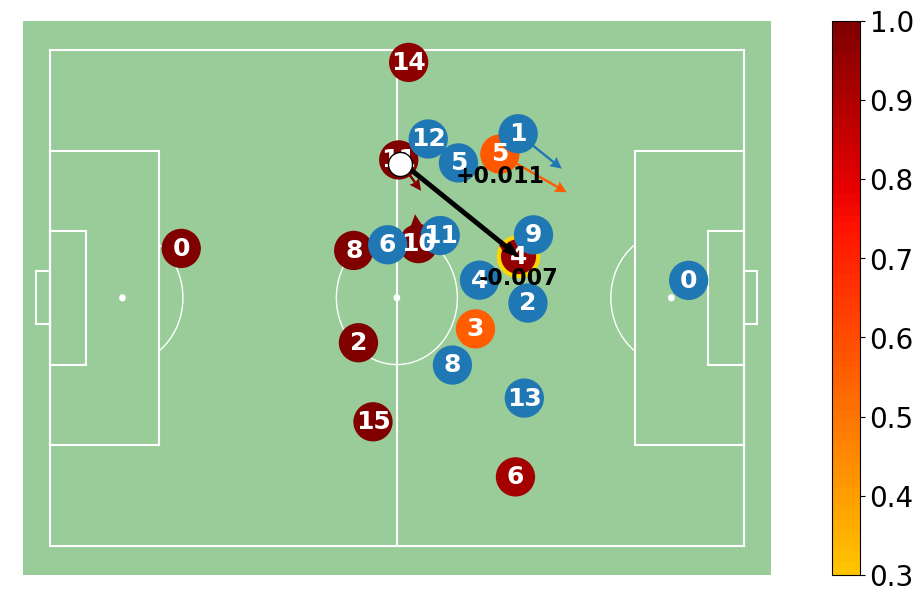

,pass_intent,pass_success,goal_if_success,goal_if_failure,oppo_agn_intent,advantage,team_credit
home_0,0.0001,0.9999,0.0063,0.0032,0.0004,-0.0059,0.0000
home_2,0.0629,0.9923,0.0134,0.0044,0.0275,0.0012,0.0000
home_3,0.0033,0.5574,0.0231,0.0062,0.0011,0.0108,0.0000
home_4,0.1320,0.9530,0.0193,0.0064,0.0799,0.0071,-0.0071
home_5,0.2292,0.5684,0.0375,0.0062,0.2939,0.0253,0.0109
home_6,0.0119,0.9213,0.0219,0.0076,0.0157,0.0097,0.0000
home_8,0.0021,0.9980,0.0133,0.0050,0.0195,0.0010,0.0000
home_10,0.5307,0.9985,0.0150,0.0055,0.3328,0.0027,0.0000
home_11,0.0000,0.9921,0.0152,0.0050,0.0000,0.0030,0.0000
home_14,0.0139,0.9676,0.0122,0.0044,0.2280,-0.0000,0.0000


In [4]:
action_index = 651
defcon.visualize(action_index, color="pass_success", annot="team_credit")

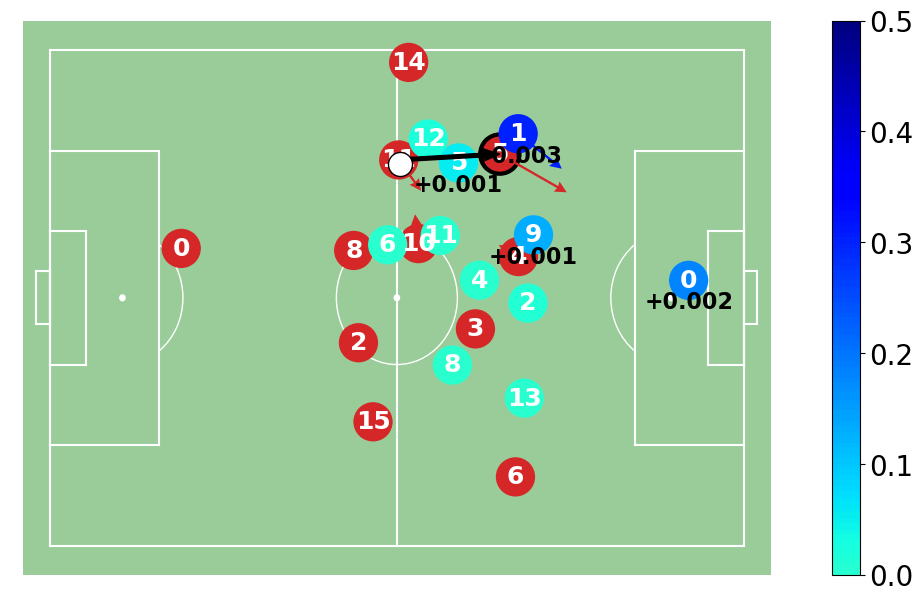

,pass_intent,pass_success,goal_if_success,goal_if_failure,oppo_agn_intent
home_0,0.0001,0.9999,0.0063,0.0032,0.0004
home_2,0.0629,0.9923,0.0134,0.0044,0.0275
home_3,0.0033,0.5574,0.0231,0.0062,0.0011
home_4,0.1320,0.9530,0.0193,0.0064,0.0799
home_5,0.2292,0.5684,0.0375,0.0062,0.2939
home_6,0.0119,0.9213,0.0219,0.0076,0.0157
home_8,0.0021,0.9980,0.0133,0.0050,0.0195
home_10,0.5307,0.9985,0.0150,0.0055,0.3328
home_11,0.0000,0.9921,0.0152,0.0050,0.0000
home_14,0.0139,0.9676,0.0122,0.0044,0.2280


In [5]:
action_index = 651
hypo_intent = 5
defcon.visualize(action_index, hypo_intent, color="posterior", annot="player_credit")